# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot   as plt
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

import xgboost as xgb

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression , Lasso
from sklearn.ensemble      import RandomForestRegressor

## 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs(y - yhat) / y)


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt( mean_squared_error( y,yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1,kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean( mae_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mae_list ), 2 ).astype( str),
                         'MAPE CV': np.round(np.mean( mape_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mape_list ), 2 ).astype( str),
                         'RMSE CV': np.round(np.mean( rmse_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( rmse_list ), 2 ).astype( str)}, index=[0])



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left',on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
56266,517,4,2015-06-11,5775,648,1,0,0,0,a,c,22490.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTIONS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions 

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of Columns: {}'.format( df1.shape[1]))

## 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
# promo2_since_week    
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval  
month_map = {1: 'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set',10:'Oct',11:'Nov',12:'Dec'}    

df1['promo_interval'].fillna(0, inplace=True ) 

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0 , axis=1 )


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [13]:
num_attributes = df1.select_dtypes( include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64' , 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [ ]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [ ]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0])

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1,3,1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot( 1,3,2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot( 1,3,3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0 FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

In [ ]:
Image( 'img/mapmindhipothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Shops Hypothesis

**1.** Stores with larger staff sell more

**2.** Stores with higher stock sell more

**3.** Larger stores should sell more

**4.** Stores with a larger assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with competitors for longer should sell more

### 2.2.2 Products Hypothesis

**1.** Stores that invest more in Marketing should sell more

**2.** Stores that display more of the product in their windows should sell more

**3.** Stores that have lower product prices should sell more

**4.** Stores with more aggressive promotions (larger discounts) should sell more

**5.** Stores with promotions active for longer should sell more

**6.** Stores with more days of promotions should sell more

**7.** Stores with more than consecutive promotions should sell more

### 2.2.3 Temporal Hypothesis

**1.** Stores open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3 Final List of Hypothesis

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer should sell more


**4.** Stores with promotions active for longer should sell more

**5.** Stores with more days of promotions should sell more

**6.** Stores with more than consecutive promotions should sell more


**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4 Feature Engineering

In [15]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , 
                                                                   month=x['competition_open_since_month'], 
                                                                   day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)

#promo since
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                                             else 'easter_holiday' if x == 'b' 
                                                                             else 'christmas' if x == 'c'
                                                                             else 'regular_day')

In [ ]:
df2.head(20).T

# 3.0 FILTERING OF VARIABLES


In [16]:
df3 = df2.copy()

In [17]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows FIltering

In [18]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [19]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop( cols_drop, axis=1)

# 4.0 EDA - EXPLORATORY DATA ANALYSIS

In [20]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [ ]:
sns.distplot(df4['sales'],kde=False);

### 4.1.2 Numerical Variable

In [ ]:
num_attributes = df4.select_dtypes( include=['int64' , 'float64'])
num_attributes.hist(bins=25);

In [ ]:
# day_of_week:  O dia da semana interfere minimamente no volume de vendas
# customers: Há uma kurtosis e um skew positivo.A quantidade de customers não influencia proporcionalmente o volume de vendas
# promo: Há maior volume de vendas quando não há promo
# school_holiday: Volume de vendas é maior quando não há school holiday
# competition_distance: Há uma kurtosis e um skew positivo. Os competidores estão muito próximos
# competition_open_since_month: Há um comportamento de subida de decréscimo constante
# competition_open_since_year: Há uma kurtosis e um skew negativo.
# promo2: Volume de vendas praticamente igual entre os dois indicadores
# promo2_since_week: Há muitas variações ao longo das semanas
# promo2_since_year:  Houve um pico nos anos de 2013 e 2014
# is_promo: Volume de vendas maior quando não há promo

### 4.1.3 Categorical Variable

In [ ]:
df4['assortment'].drop_duplicates()

In [ ]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True);
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True);
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True);

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True);
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True);


## 4.2 Bivariate Analysis

### H1. Stores with a larger assortment should sell more - FALSE

In [ ]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week',columns= 'assortment',values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week',columns= 'assortment',values='sales').plot();

### H2. Stores with closer competitors should sell less - FALSE



In [ ]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Stores with competitors for longer should sell more - FALSE

In [ ]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);


### H4. Stores with promotions active for longer should sell more - FALSE

In [ ]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'),annot=True);

### <s>H5. Stores with more days of promotions should sell more </s>


### H6. Stores with more than consecutive promotions should sell more - FALSE

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

In [ ]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend( labels=['Traditional & Extended', 'Extended']);

### H7. Stores open during the Christmas holiday should sell more - FALSE

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday' , y='sales', data= aux1);

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x='year' , y='sales', hue='state_holiday' ,data= aux2);

### H8. Stores should sell more over the years - FALSE

In [ ]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H9. Stores should sell more in the second half of the year - FALSE

In [ ]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H10. Stores should sell more after the 10th of each month - TRUE

In [ ]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,2)
sns.regplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after' , y='sales' , data=aux2);

### H11. Stores should sell less on weekends - TRUE

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H12. Stores should sell less during school holidays - TRUE, EXCEPT JULY AND AUGUST

In [ ]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday' , y='sales' , data=aux1 );

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month' , y='sales' , hue='school_holiday', data=aux2 );

### 4.2.1 Hypotesis Resume

In [ ]:
from tabulate import tabulate

In [ ]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Average'],
      ['H3', 'False', 'Average'],  
      ['H4', 'False', 'Low'], 
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Average'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow'))

## 4.3 Multivariate Analysis


### 4.3.1 Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] } )

d = d.set_index( d.columns)

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [21]:
df5 = df4.copy()

## 5.1 Normalization

In [ ]:
# There are not normal variables to normalize

## 5.2 Rescaling

In [22]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

In [ ]:
plt.subplot(2,2,1)
sns.distplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.distplot(df5['competition_time_month']);

plt.subplot(2,2,3)
sns.distplot(df5['promo_time_week']);

plt.subplot(2,2,4)
sns.distplot(df5['year']);

## 5.3 Transformation

### 5.3.1 Encoding

In [23]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'],columns= ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

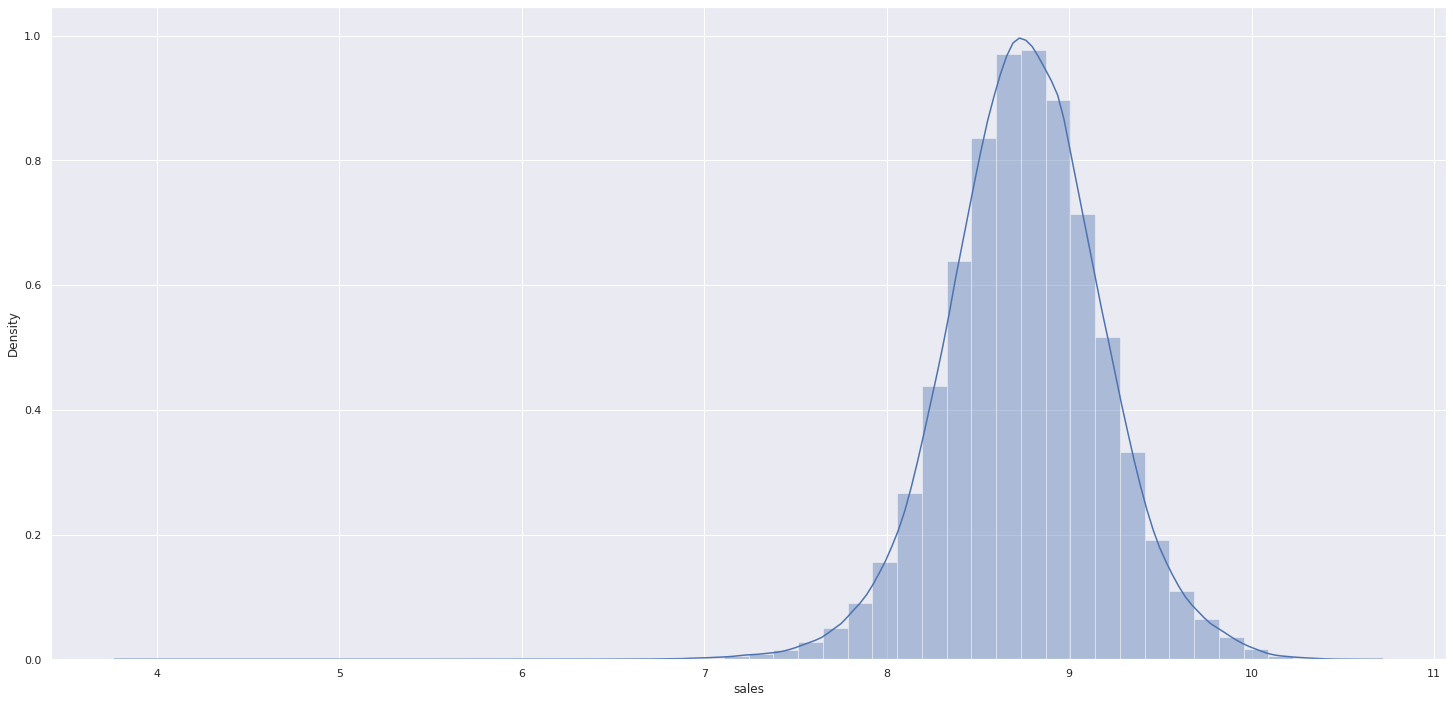

In [24]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

In [25]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )


# 6.0 FEATURE SELECTION

In [26]:
df6 = df5.copy()

In [ ]:
# df6 = df6.sample(50000)

## 6.1 Split dataframe into training and test dataset

In [27]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop (cols_drop , axis=1)

In [28]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days =6*7 )

Timestamp('2015-06-19 00:00:00')

In [29]:
# # training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# # test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min() ) )
print( 'Training Max Date: {}'.format( x_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
# # training and test dataset for Boruta
# x_train_n = x_train.drop(['date','sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# # # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n , y_train_n)

## 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# # # best features
# x_train_fs = x_train.drop(['date','sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# # # not selected boruta
# cols_not_selected = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

## 6.3 Manual Feature Selection

In [30]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [31]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Machine Learning Modeling

In [32]:
X_train = x_train[ cols_selected_boruta]
X_test = x_test[ cols_selected_boruta]

# Time Series Data Preparation
x_training = x_train[cols_selected_boruta_full]

## 7.1 Average Model

In [33]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store' , 'sales']].groupby( 'store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge( aux1, aux2 , how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [34]:
# model
lr = LinearRegression().fit( X_train, y_train)

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test) , np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [35]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [36]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train)

# prediction
yhat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test) , np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [37]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [41]:
# model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42 ).fit( X_train, y_train)

# prediction
yhat_rf = rf.predict( X_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.431113,0.10075,1018.684119


### 7.4.1 Random Forest Regressor - Cross Validation

In [43]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,842.56 +/- 220.07,0.12 +/- 0.02,1264.33 +/- 323.29


## 7.5 XGBoost Regressor

In [38]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( X_train, y_train)      

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6739,0.949475,7330.979785


### 7.5.1 XGBoost Regressor - Cross Validation

In [39]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [44]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.431113,0.100750,1018.684119
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.673900,0.949475,7330.979785


### 7.6.2 Real Performance - Cross Validation

In [47]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,842.56 +/- 220.07,0.12 +/- 0.02,1264.33 +/- 323.29
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.16 +/- 588.44,0.95 +/- 0.0,7715.2 +/- 689.21
